In [1]:
%run flow_tools.py

In [2]:
from matplotlib.path import Path
from matplotlib import patches

In [3]:
folders = ['../data/20220411_Spike_SynNotch_classic_new/']

In [4]:
df = pd.concat([load_data(folder, colnames = ["WellName", "Receiver", "Sender",'Replicate'])
               for folder in folders], ignore_index=True)

In [5]:
#remove NAs
df2= df.loc[(df.select_dtypes(include=['number']) > 0).all(axis='columns'), :]
df2=df2.dropna()

In [6]:
#define gate for FSC-A vs SSC-A
fsc_ssc_verts = [(4e4, 1e4),
              (1e5, 2.5e4),
              (2.5e5, 1e5),
              (2.5e5, 2.5e5),
              (1e5, 2.5e5),
              (4e4, 5e4),
              (4e4, 5e4),
              (4e4, 1e4)]
fsc_ssc_gate = Path(fsc_ssc_verts)

ssc_verts = [(0, 1e4),
              (2e5, 1.8e5),
              (2.6e5, 1.8e5),
              (2.5e5, 1.3e5),
              (1.25e5, 7.5e4),
              (1e4, 0),
              (0, 1e4)]
ssc_gate = Path(ssc_verts)

In [ ]:
fig, axs = plt.subplots(2,2, figsize=[10,10])
sns.scatterplot(data=df2[(df2['WellName'].isin(['A04']))], x='FSC-A', y='SSC-A', marker='o', s=5, edgecolors=None, ax=axs[0,0], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['A04'])], x='SSC-A', y='SSC-H', marker='o', s=5, edgecolors=None, ax=axs[0,1], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['B01'])], x='FSC-A', y='SSC-A', marker='o', s=5, edgecolors=None, ax=axs[1,0], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['B01'])], x='SSC-A', y='SSC-H', marker='o', s=5, edgecolors=None, ax=axs[1,1], hue='WellName')
patch = patches.PathPatch(fsc_ssc_gate, facecolor="None", edgecolor='k')
axs[0,0].add_patch(patch)
patch = patches.PathPatch(fsc_ssc_gate, facecolor="None", edgecolor='k')
axs[1,0].add_patch(patch)
patch = patches.PathPatch(ssc_gate, facecolor="None", edgecolor='k')
axs[0,1].add_patch(patch)
patch = patches.PathPatch(ssc_gate, facecolor="None", edgecolor='k')
axs[1,1].add_patch(patch)
plt.tight_layout()

In [7]:
#filter to gate
df2 = df2[fsc_ssc_gate.contains_points(df2[['FSC-A','SSC-A']].to_numpy())]
df2 = df2[ssc_gate.contains_points(df2[['SSC-A', 'SSC-H']].to_numpy())]
# # gate on singlets
# df2 = gate_density(df2, 0.1, x_var='SSC-A',y_var='SSC-H')

for col in df2.columns:
        if df2[col].dtype=="float32":
            df2["log"+ col]=df2[col].apply(math.log10)

In [9]:
notches = ['No Notch','LCB1-SNIPR', 'LCB3-SNIPR']
filters = ((df2['logFITC-A'] > 5) &
           (df2.Receiver.isin(notches)))
dist = df2[filters]['logDAPI-A'].values[:,np.newaxis]
model = GaussianMixture(2, covariance_type='spherical', random_state=237).fit(dist)
off_component = np.argmin(model.means_)
df_summary = (df2[filters]
              .groupby(['Sender','Receiver','Replicate'])['logDAPI-A']
              .apply(lambda x: 100*(1-np.sum(model.predict(x.values[:,np.newaxis])==off_component)/len(x)))
              .reset_index())

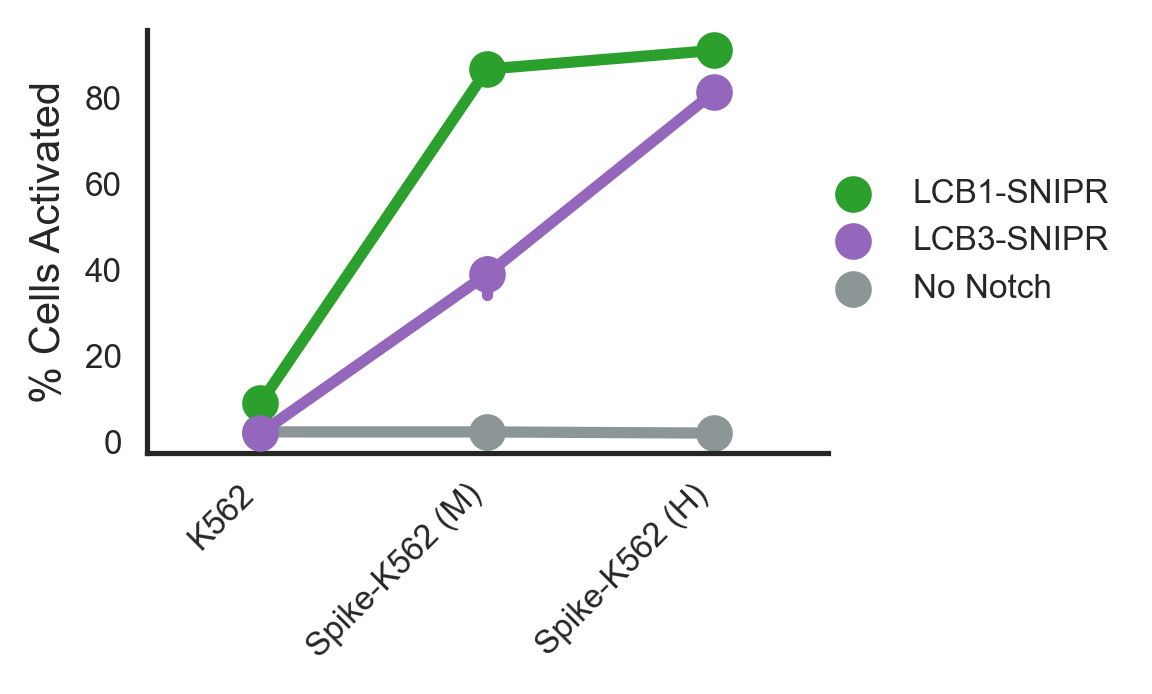

In [10]:
with sns.color_palette(["#8C9696", "#2ca02c", "#9467bd"]):
    g = sns.catplot(kind='point', data=df_summary[(df_summary['Receiver'].isin(notches))],
                    y='logDAPI-A', x='Sender', hue='Receiver', join=True, 
                    order=['K562', 'Spike-K562 (M)', 'Spike-K562 (H)'], 
                    hue_order=notches, height=2, aspect=1.5)
    g.set_xticklabels(rotation=45, ha='right')
    g.legend.remove()
    plt.xlabel('')
    plt.ylabel('% Cells Activated')
    handles, labels = g.ax.get_legend_handles_labels()
    order = [1,2,0]
    plt.legend([handles[idx] for idx in order],
               [labels[idx] for idx in order],
               frameon=False, loc='center', bbox_to_anchor=(1.2,0.5))
    g.fig.set_dpi(300)

In [12]:
notches = ['No Notch','LCB1-SNIPR', 'LCB3-SNIPR']
filters = ((df2['logFITC-A'] > 5) &
           (df2.Receiver.isin(notches)))
df_summary = (df2[filters]
              .groupby(['Sender','Receiver','Replicate'])['logDAPI-A']
              .median()
              .reset_index())

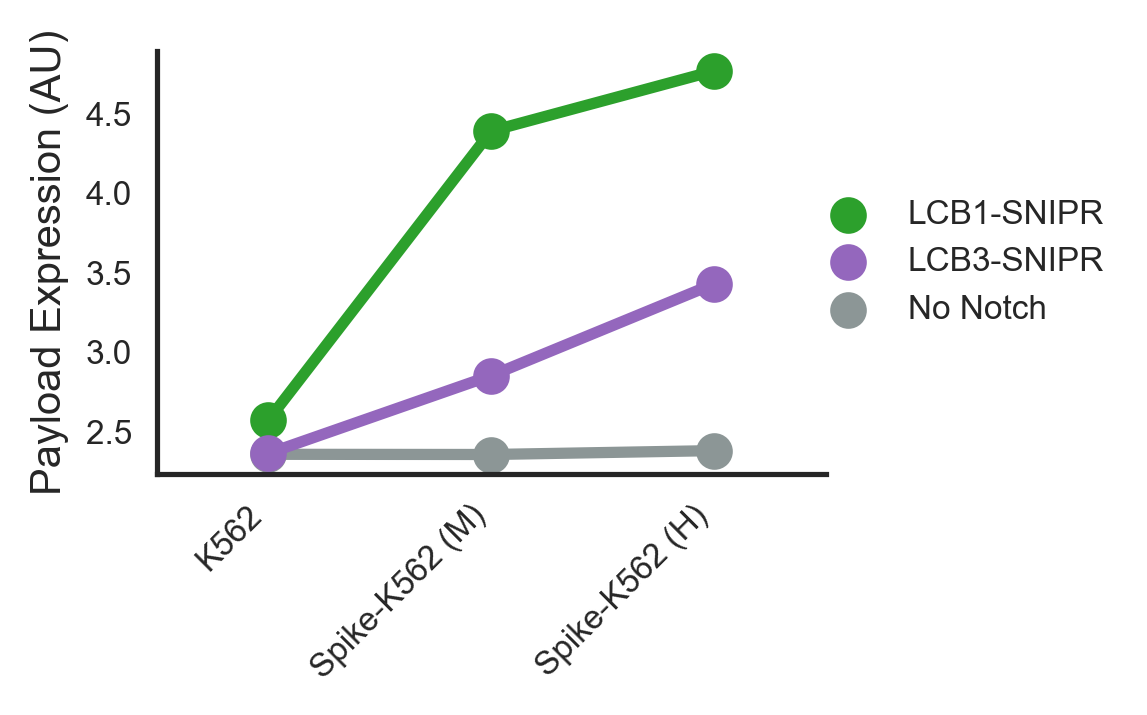

In [13]:
with sns.color_palette(["#8C9696", "#2ca02c", "#9467bd"]):
    g = sns.catplot(kind='point', data=df_summary[(df_summary['Receiver'].isin(notches))],
                    y='logDAPI-A', x='Sender', hue='Receiver', join=True, 
                    order=['K562', 'Spike-K562 (M)', 'Spike-K562 (H)'], 
                    hue_order=notches, height=2, aspect=1.5)
    g.set_xticklabels(rotation=45, ha='right')
    g.legend.remove()
    plt.xlabel('')
    plt.ylabel('Payload Expression (AU)')
    handles, labels = g.ax.get_legend_handles_labels()
    order = [1,2,0]
    plt.legend([handles[idx] for idx in order],
               [labels[idx] for idx in order],
               frameon=False, loc='center', bbox_to_anchor=(1.2,0.5))
    g.fig.set_dpi(300)

In [15]:
df2[df2['Receiver'].isin(['None','No Notch','LCB1-SNIPR', 'LCB3-SNIPR'])].to_csv('snipr_res.csv')

Text(0.5, 22.959999999999958, 'log <channel>')

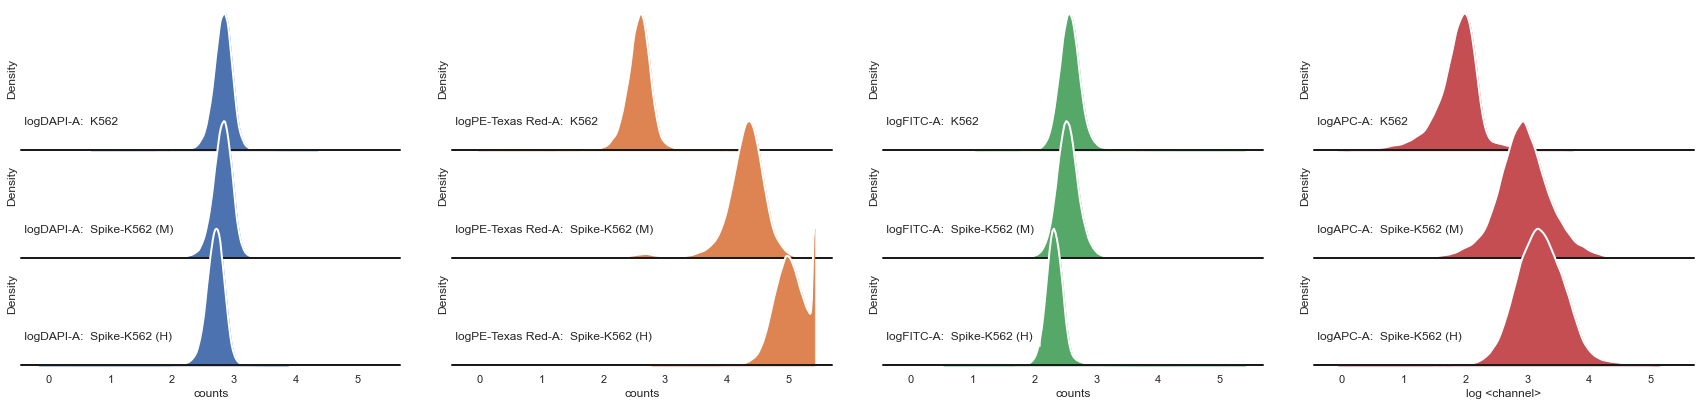

In [13]:
# To figure out what our cutoffs should be, let's look at the untransfected cells for all 4 channels:
# This plots each channel as a column of graphs, and each cell line per row
simplified_df = (df2.reset_index()
                 .melt(value_vars=['logDAPI-A','logPE-Texas Red-A','logFITC-A', 'logAPC-A'], 
                       id_vars=['index','WellName','Sender','Receiver'],
                       var_name='channel',
                       value_name='counts'))
g = sns.FacetGrid(data=simplified_df[(simplified_df["Receiver"].isin(['None']))], 
                  row = 'Sender', col='channel', hue='channel', sharey=False, aspect=3, height=2)
g.map(sns.kdeplot, "counts", shade=True, alpha=1, bw_adjust=0.9, clip_on=False, cut=0)
g.map(sns.kdeplot, "counts", color="w", lw=2, bw_adjust=.9, clip_on=False, cut=0)
g.map(plt.axhline, y=0, lw=2, color='k', clip_on=False)

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

for ax in g.axes.flat:
    wellname = ax.get_title().split("=")[2]
    ch = ax.get_title().split('|')[0].split('=')[1]
    ax.text(0,0.2, "{}: {}".format(wellname, ch), ha="left", va="center", 
            bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
    ax.set(facecolor=(0, 0, 0, 0))

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.xlabel("log <channel>")

Text(0.5, 22.959999999999894, 'log <channel>')

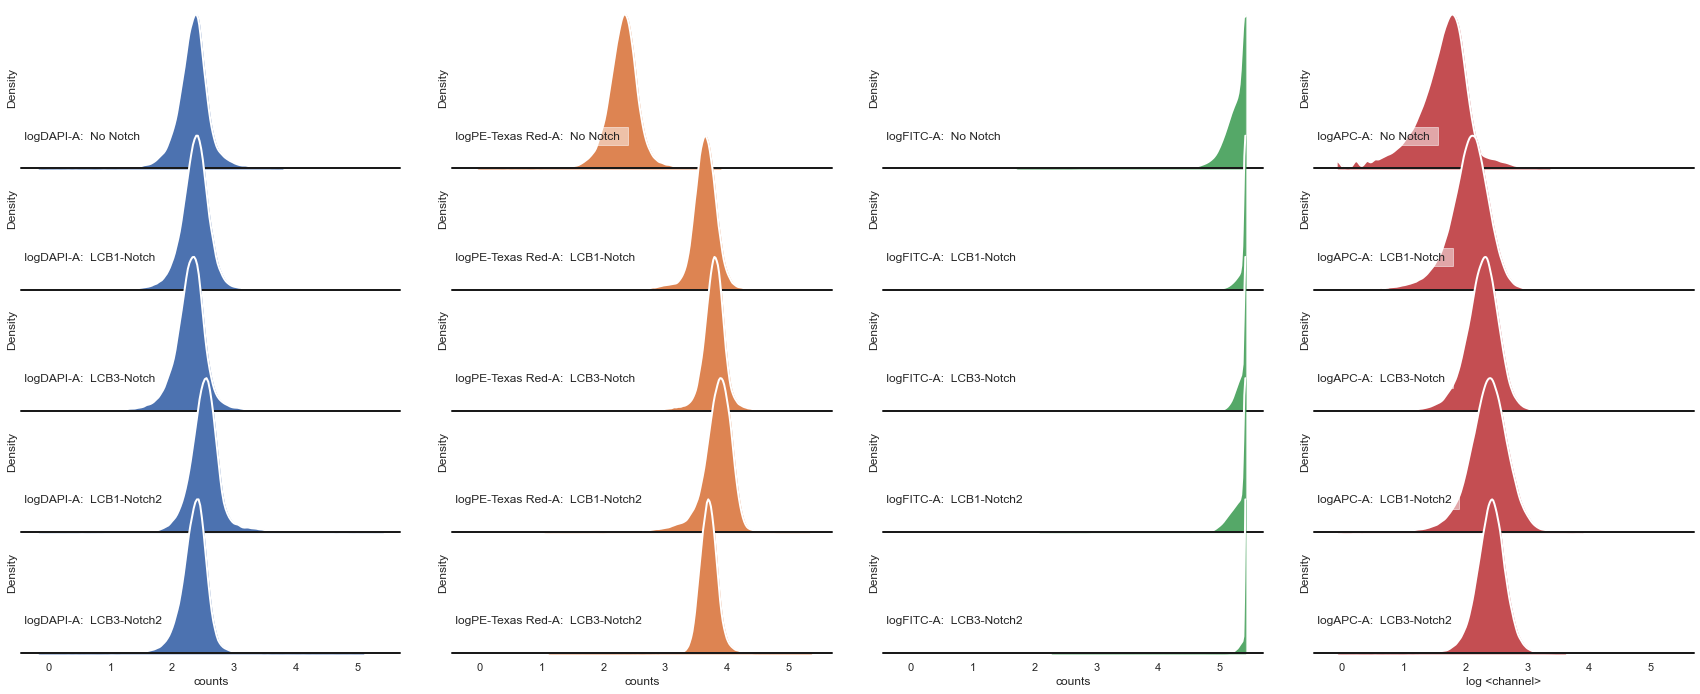

In [14]:
# To figure out what our cutoffs should be, let's look at the untransfected cells for all 4 channels:
# This plots each channel as a column of graphs, and each cell line per row
simplified_df = (df2.reset_index()
                 .melt(value_vars=['logDAPI-A','logPE-Texas Red-A','logFITC-A', 'logAPC-A'], 
                       id_vars=['index','WellName','Sender','Receiver'],
                       var_name='channel',
                       value_name='counts'))
g = sns.FacetGrid(data=simplified_df[(simplified_df["Sender"].isin(['None']))], 
                  row = 'Receiver', col='channel', hue='channel', sharey=False, aspect=3, height=2)
g.map(sns.kdeplot, "counts", shade=True, alpha=1, bw_adjust=0.9, clip_on=False, cut=0)
g.map(sns.kdeplot, "counts", color="w", lw=2, bw_adjust=.9, clip_on=False, cut=0)
g.map(plt.axhline, y=0, lw=2, color='k', clip_on=False)

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

for ax in g.axes.flat:
    wellname = ax.get_title().split("=")[2]
    ch = ax.get_title().split('|')[0].split('=')[1]
    ax.text(0,0.2, "{}: {}".format(wellname, ch), ha="left", va="center", 
            bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
    ax.set(facecolor=(0, 0, 0, 0))

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.xlabel("log <channel>")

In [11]:
expression_df = (df2[(df2['Receiver']=='None')]
                 .groupby(['Sender','Replicate'])['PE-Texas Red-A']
                 .mean()
                 .reset_index())

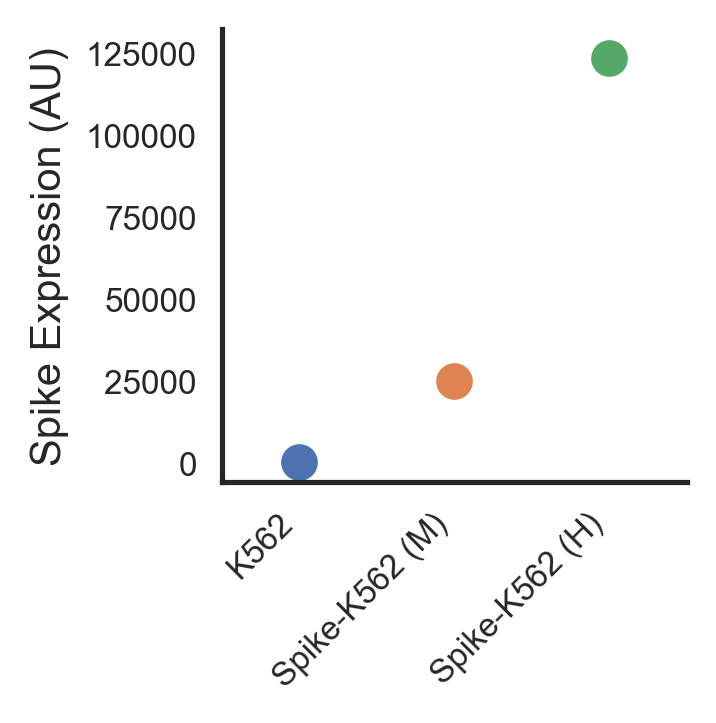

In [13]:
fig, ax = plt.subplots(1,1,figsize=(2,2), dpi=300)
g = sns.pointplot(data=expression_df, x='Sender', y='PE-Texas Red-A', hue='Sender', 
                  kind='point', join=False, 
                  order=['K562', 'Spike-K562 (M)', 'Spike-K562 (H)'],
                  hue_order=['K562', 'Spike-K562 (M)', 'Spike-K562 (H)'])
g.legend().remove()
g.set_ylabel('Spike Expression (AU)')
g.set_xlabel('')
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.savefig(outputdir+'target-expression.eps', bbox_inches='tight')